# Final Project - Imitation Learning from Suboptimal Demonstrations

### Notebook 1: Exploration with Multiple Agents (HalfCheetah-v1)

### Set up gym environment
The code below does the following for you:
- Wrap environment, log videos, setup CUDA variables (if GPU is available)
- Record action and observation space dimensions
- Fix random seed for determinisitic training

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import random
import os
import time
import itertools

#environment
import gym

#pytorch
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

logging_interval = 20
animate_interval = logging_interval * 5
logdir='./test_DDPG/'

# make variable types for automatic setting to GPU or CPU, depending on GPU availability
use_cuda = torch.cuda.is_available()
FloatTensor = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if use_cuda else torch.LongTensor
ByteTensor = torch.cuda.ByteTensor if use_cuda else torch.ByteTensor
Tensor = FloatTensor

# REINFORCE

In this section you will implement REINFORCE, with modifications for batch training. It will be for use on both discrete and continous action spaces.

### Implement an action normalization class:
To train across various environments, it is useful to normalize action inputs and outputs between [-1, 1]. This class should take in actions and implement forward and reverse functions to map actions between [-1, 1] and [action_space.low, action_space.high].

Using the following gym wrapper, implement this class.
- https://github.com/openai/gym/blob/78c416ef7bc829ce55b404b6604641ba0cf47d10/gym/core.py
- i.e. we are overriding the outputs scale of actions. 

In [2]:
class NormalizeAction(gym.ActionWrapper):
    def __init__(self, env=None):
        super(NormalizeAction, self).__init__(env)
        
    def _action(self, action):
        #tanh outputs (-1,1) from tanh, need to be [action_space.low, action_space.high]
        r = (self.action_space.high - self.action_space.low) / 2.
        mid = (self.action_space.high + self.action_space.low) / 2.
        return mid + r * action
    
    def _reverse_action(self, action):
        #reverse of that above
        r_inv = 2. / (self.action_space.high - self.action_space.low)
        mid = (self.action_space.high + self.action_space.low) / 2.
        return r_inv * (action - mid)

## Policy Parametrization

Define a MLP which outputs a distribution over the action preferences given input state. For the discrete case, the MLP outputs the likelihood of each action (softmax) while for the continuous case, the output is the mean and standard deviation parametrizing the normal distribution from which the action is sampled.



In [4]:
# ----------------------------------------------------
# Policy parametrizing model, MLP
# ----------------------------------------------------
# 1 or 2 hidden layers with a small number of units per layer (similar to DQN)
# use ReLU for hidden layer activations
# softmax as activation for output if discrete actions, linear for continuous control
# for the continuous case, output_dim=2*act_dim (each act_dim gets a mean and std_dev)

class mlp(nn.Module):
    def __init__(self, discrete, input_size, output_size, hidden_size=16):
        super(mlp, self).__init__()
        self.discrete = discrete
        
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        if self.discrete:
            self.fc3 = nn.Linear(hidden_size, output_size)
        else:
            self.fc3 = nn.Linear(hidden_size, output_size*2)
            
        self.fc1.weight.data.normal_(0, 0.1)
        self.fc2.weight.data.normal_(0, 0.1)
        self.fc3.weight.data.normal_(0, 0.1)

    def forward(self, x):
        x = Variable(Tensor(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        if self.discrete:
            x = F.softmax(self.fc3(x), dim=0)
        else:
            x = self.fc3(x)
        return x

Define a function that samples an action from the policy distribtion parameters obtained as output of the MLP. The function should return the action and the log-probability (log_odds) of taking that action. 

In [3]:
def sample_action(logit, discrete):
    # logit is the output of the softmax/linear layer
    # discrete is a flag for the environment type
    # Hint: use Categorical and Normal from torch.distributions to sample action and get the log-probability
    # Note that log_probability in this case translates to ln(\pi(a|s)) 
    if discrete:
        m = torch.distributions.Categorical(logit)
    else:
        l = int(logit.data.shape[-1]/2)
        if len(logit.data.shape) == 1:
            m = torch.distributions.Normal(logit[l:], F.softplus(logit[:l]))
        else:
            m = torch.distributions.Normal(logit[:,l:], F.softplus(logit[:,:l]))
    action = m.sample()
    log_odds = m.log_prob(action)
    return action, log_odds

Create a function update_policy that defines the loss function and updates the MLP according to the REINFORCE update rule (ref. slide 24 of Lec 7 or page 330 of Sutton and Barto (2018)). The update algorithm to be used below is slightly different: instead of updating the network at every time-step, we take the gradient of the loss averaged over a batch of timesteps (this is to make SGD more stable). We also use a baseline to reduce variance. 

The discount factor is set as 1 here. 


In [5]:
def update_policy(paths, net):
    # paths: a list of paths (complete episodes, used to calculate return at each time step)
    # net: MLP object
    
    num_paths = len(paths)
    rew_cums = []
    log_odds = []
    policy_loss = []
    
    for path in paths:
        # rew_cums should record return at each time step for each path 
        rews = path['reward']
        R = 0
        for r in rews[::-1]:
            R = r + R
            rew_cums.append(R)
        
        # log_odds should record log_odds obtained at each timestep of path
        los = path['log_odds']
        for lo in los[::-1]:
            log_odds.append(lo)
         
        # calculated as "reward to go"
 
    # make log_odds, rew_cums each a vector
    rew_cums = torch.Tensor(np.asarray(rew_cums))    
    rew_cums = (rew_cums - rew_cums.mean()) / (rew_cums.std() + 1e-5) # create baseline
        
    # calculate policy loss and average over paths
    for log_prob, reward in zip(log_odds, rew_cums):
        policy_loss.append(-log_prob * reward)
    policy_loss = torch.cat(policy_loss).sum()
    
    # take optimizer step
    optimizer.zero_grad()
    policy_loss.backward()
    optimizer.step()

Set up environment and instantiate objects. Your algorithm is to be tested on one discrete and two continuous environments. 



In [6]:
# Select Environment

# discrete environment:
# env_name = 'CartPole-v0'

# continous environments:
# env_name = 'InvertedPendulum-v1'
env_name = 'HalfCheetah-v1'

# Make the gym environment
env = gym.make(env_name)
visualize = False
animate = visualize

learning_rate = 1e-3

max_path_length = 500

# Set random seeds
seed = 0
torch.manual_seed(seed)
np.random.seed(seed)

# Saving parameters
logdir='./test_REINFORCE/'

env._max_episode_steps = max_path_length
if visualize:
    if not os.path.exists(logdir):
        os.mkdir(logdir)
    env = gym.wrappers.Monitor(env, logdir, force=True, video_callable=lambda episode_id: episode_id%animate_interval==0)

# Is this env continuous, or discrete?
discrete = isinstance(env.action_space, gym.spaces.Discrete)

# Get observation and action space dimensions
obs_dim = env.observation_space.shape[0]
act_dim = env.action_space.n if discrete else env.action_space.shape[0]
print('obs_dim: ', obs_dim)
print('act_dim: ', act_dim)
print('max_episode_steps: ', env.spec.max_episode_steps)

# Maximum length for episodes
max_path_length = max_path_length or env.spec.max_episode_steps

# Normalize action
env = NormalizeAction(env)

# Make network object (remember to pass in appropriate flags for the type of action space in use)
net = mlp(discrete, obs_dim, act_dim)

# Make optimizer
optimizer = torch.optim.Adam(net.parameters(), lr = learning_rate)

[2018-06-05 12:57:12,972] Making new env: HalfCheetah-v1
[2018-06-05 12:57:13,409] Clearing 88 monitor files from previous run (because force=True was provided)


obs_dim:  17
act_dim:  6
max_episode_steps:  1000


## Run REINFORCE

Run REINFORCE for CartPole, InvertedPendulum, and HalfCheetah. 

In [7]:
n_iter = 2000 
min_timesteps_per_batch = 2000 # sets the batch size for updating network
avg_reward = 0
avg_rewards = []
step_list_reinforce = []
total_steps = 0
episodes = 0

# term_condition = 100 # CartPole
term_condition = 100 # HalfCheetah
# term_condition = 100 # InvertedPendulum

#done = False
#while not done:
#    _, _, done, _ = env.step(np.zeros(act_dim, dtype=np.int))

for itr in range(n_iter): # loop for number of optimization steps
    paths = []
    steps = 0
    
    while True: # loop to get enough timesteps in this batch --> if episode ends this loop will restart till steps reaches limit
        ob = env.reset()
        obs, acs, rews, log_odds = [], [], [], []
       
        while True: # loop for episode inside batch
            #if animate:
            #    env.render()
            #    time.sleep(0.05)
            
            # get parametrized policy distribution from net using current state ob
            net.eval()
            logit = net(ob)
            net.train()
            
            # sample action and get log-probability (log_odds) from distribution
            action, log_prob = sample_action(logit, discrete)
            action = np.clip(action.data.numpy(), -1, 1)
            # action = action[0] # for CartPole only
            
            # step environment, record reward, next state
            next_ob, reward, done, _ = env.step(action)
            steps += 1
            
            # append to obs, acs, rewards, log_odds
            obs.append(ob)
            acs.append(action)
            rews.append(reward)
            log_odds.append(log_prob)
            
            # if done, restart episode till min_timesteps_per_batch is reached                     
            if done:
                episodes = episodes + 1
                break
                
            ob = next_ob
                
        path = {"observation" : np.array(obs), 
                "reward" : np.array(rews), 
                "action" : np.array(acs),
                "log_odds" : log_odds}
        
        paths.append(path)
        
        if steps > min_timesteps_per_batch:
            break 
        
    update_policy(paths, net) # use all complete episodes (a batch of timesteps) recorded in this itr to update net
    
    if itr == 0:
        avg_reward = path['reward'].sum()
    else:
        avg_reward = 0.95 * avg_reward + 0.05 * path['reward'].sum()
    
    if avg_reward > term_condition:
        break
    
    total_steps += steps
    avg_rewards.append(avg_reward)
    step_list_reinforce.append(total_steps)
    if itr % logging_interval == 0:
        print("Average reward: {} for episode: {}".format(avg_reward, episodes))
        
env.close()

[2018-06-04 19:56:29,429] Starting new video recorder writing to /Users/hank/Documents/UCSD/ECE276C/hw4/test_REINFORCE/openaigym.video.0.33234.video000000.mp4


Average reward: -190.17590515603456 for episode: 5


[2018-06-04 19:57:26,241] Starting new video recorder writing to /Users/hank/Documents/UCSD/ECE276C/hw4/test_REINFORCE/openaigym.video.0.33234.video000100.mp4


Average reward: -176.6483991942267 for episode: 105


[2018-06-04 19:58:19,782] Starting new video recorder writing to /Users/hank/Documents/UCSD/ECE276C/hw4/test_REINFORCE/openaigym.video.0.33234.video000200.mp4


Average reward: -143.9750315760934 for episode: 205


[2018-06-04 19:59:14,146] Starting new video recorder writing to /Users/hank/Documents/UCSD/ECE276C/hw4/test_REINFORCE/openaigym.video.0.33234.video000300.mp4


Average reward: -155.4177168291811 for episode: 305


[2018-06-04 20:00:10,596] Starting new video recorder writing to /Users/hank/Documents/UCSD/ECE276C/hw4/test_REINFORCE/openaigym.video.0.33234.video000400.mp4


Average reward: -164.46873550449328 for episode: 405


[2018-06-04 20:01:04,148] Starting new video recorder writing to /Users/hank/Documents/UCSD/ECE276C/hw4/test_REINFORCE/openaigym.video.0.33234.video000500.mp4


Average reward: -140.87998390479873 for episode: 505


[2018-06-04 20:01:57,062] Starting new video recorder writing to /Users/hank/Documents/UCSD/ECE276C/hw4/test_REINFORCE/openaigym.video.0.33234.video000600.mp4


Average reward: -139.2746423515086 for episode: 605


[2018-06-04 20:02:51,551] Starting new video recorder writing to /Users/hank/Documents/UCSD/ECE276C/hw4/test_REINFORCE/openaigym.video.0.33234.video000700.mp4


Average reward: -128.64198865367817 for episode: 705


[2018-06-04 20:03:44,311] Starting new video recorder writing to /Users/hank/Documents/UCSD/ECE276C/hw4/test_REINFORCE/openaigym.video.0.33234.video000800.mp4


Average reward: -130.31646945890165 for episode: 805


[2018-06-04 20:04:38,312] Starting new video recorder writing to /Users/hank/Documents/UCSD/ECE276C/hw4/test_REINFORCE/openaigym.video.0.33234.video000900.mp4


Average reward: -116.99806774936954 for episode: 905


[2018-06-04 20:05:43,833] Starting new video recorder writing to /Users/hank/Documents/UCSD/ECE276C/hw4/test_REINFORCE/openaigym.video.0.33234.video001000.mp4


Average reward: -121.08294887856327 for episode: 1005


[2018-06-04 20:06:47,422] Starting new video recorder writing to /Users/hank/Documents/UCSD/ECE276C/hw4/test_REINFORCE/openaigym.video.0.33234.video001100.mp4


Average reward: -124.66034169726 for episode: 1105


[2018-06-04 20:07:52,593] Starting new video recorder writing to /Users/hank/Documents/UCSD/ECE276C/hw4/test_REINFORCE/openaigym.video.0.33234.video001200.mp4


Average reward: -112.49652491079135 for episode: 1205


[2018-06-04 20:08:57,545] Starting new video recorder writing to /Users/hank/Documents/UCSD/ECE276C/hw4/test_REINFORCE/openaigym.video.0.33234.video001300.mp4


Average reward: -101.08036109428963 for episode: 1305


[2018-06-04 20:09:50,058] Starting new video recorder writing to /Users/hank/Documents/UCSD/ECE276C/hw4/test_REINFORCE/openaigym.video.0.33234.video001400.mp4


Average reward: -97.8937455051809 for episode: 1405


[2018-06-04 20:10:43,778] Starting new video recorder writing to /Users/hank/Documents/UCSD/ECE276C/hw4/test_REINFORCE/openaigym.video.0.33234.video001500.mp4


Average reward: -88.73662103829186 for episode: 1505


[2018-06-04 20:11:38,183] Starting new video recorder writing to /Users/hank/Documents/UCSD/ECE276C/hw4/test_REINFORCE/openaigym.video.0.33234.video001600.mp4


Average reward: -93.97683684945717 for episode: 1605


[2018-06-04 20:12:31,430] Starting new video recorder writing to /Users/hank/Documents/UCSD/ECE276C/hw4/test_REINFORCE/openaigym.video.0.33234.video001700.mp4


Average reward: -82.42970482411627 for episode: 1705


[2018-06-04 20:13:25,525] Starting new video recorder writing to /Users/hank/Documents/UCSD/ECE276C/hw4/test_REINFORCE/openaigym.video.0.33234.video001800.mp4


Average reward: -81.29354750065112 for episode: 1805


[2018-06-04 20:14:18,820] Starting new video recorder writing to /Users/hank/Documents/UCSD/ECE276C/hw4/test_REINFORCE/openaigym.video.0.33234.video001900.mp4


Average reward: -75.23860491174933 for episode: 1905


[2018-06-04 20:15:12,521] Starting new video recorder writing to /Users/hank/Documents/UCSD/ECE276C/hw4/test_REINFORCE/openaigym.video.0.33234.video002000.mp4


Average reward: -68.5569144611808 for episode: 2005


[2018-06-04 20:16:06,033] Starting new video recorder writing to /Users/hank/Documents/UCSD/ECE276C/hw4/test_REINFORCE/openaigym.video.0.33234.video002100.mp4


Average reward: -54.85973711577107 for episode: 2105


[2018-06-04 20:17:00,026] Starting new video recorder writing to /Users/hank/Documents/UCSD/ECE276C/hw4/test_REINFORCE/openaigym.video.0.33234.video002200.mp4


Average reward: -73.1807570689975 for episode: 2205


[2018-06-04 20:17:52,782] Starting new video recorder writing to /Users/hank/Documents/UCSD/ECE276C/hw4/test_REINFORCE/openaigym.video.0.33234.video002300.mp4


Average reward: -70.41634408191376 for episode: 2305


[2018-06-04 20:18:46,927] Starting new video recorder writing to /Users/hank/Documents/UCSD/ECE276C/hw4/test_REINFORCE/openaigym.video.0.33234.video002400.mp4


Average reward: -61.018754905466295 for episode: 2405


[2018-06-04 20:19:40,938] Starting new video recorder writing to /Users/hank/Documents/UCSD/ECE276C/hw4/test_REINFORCE/openaigym.video.0.33234.video002500.mp4


Average reward: -63.081412606459814 for episode: 2505


[2018-06-04 20:20:35,382] Starting new video recorder writing to /Users/hank/Documents/UCSD/ECE276C/hw4/test_REINFORCE/openaigym.video.0.33234.video002600.mp4


Average reward: -58.87066945370574 for episode: 2605


[2018-06-04 20:21:27,947] Starting new video recorder writing to /Users/hank/Documents/UCSD/ECE276C/hw4/test_REINFORCE/openaigym.video.0.33234.video002700.mp4


Average reward: -49.55951335486672 for episode: 2705


[2018-06-04 20:22:20,172] Starting new video recorder writing to /Users/hank/Documents/UCSD/ECE276C/hw4/test_REINFORCE/openaigym.video.0.33234.video002800.mp4


Average reward: -40.17972487150962 for episode: 2805


[2018-06-04 20:23:14,040] Starting new video recorder writing to /Users/hank/Documents/UCSD/ECE276C/hw4/test_REINFORCE/openaigym.video.0.33234.video002900.mp4


Average reward: -40.329303130856886 for episode: 2905


[2018-06-04 20:24:06,409] Starting new video recorder writing to /Users/hank/Documents/UCSD/ECE276C/hw4/test_REINFORCE/openaigym.video.0.33234.video003000.mp4


Average reward: -28.29185161763555 for episode: 3005


[2018-06-04 20:25:00,241] Starting new video recorder writing to /Users/hank/Documents/UCSD/ECE276C/hw4/test_REINFORCE/openaigym.video.0.33234.video003100.mp4


Average reward: -26.227948672282512 for episode: 3105


[2018-06-04 20:25:53,401] Starting new video recorder writing to /Users/hank/Documents/UCSD/ECE276C/hw4/test_REINFORCE/openaigym.video.0.33234.video003200.mp4


Average reward: -26.590288942040306 for episode: 3205


[2018-06-04 20:26:47,286] Starting new video recorder writing to /Users/hank/Documents/UCSD/ECE276C/hw4/test_REINFORCE/openaigym.video.0.33234.video003300.mp4


Average reward: -22.19063476853711 for episode: 3305


[2018-06-04 20:27:39,750] Starting new video recorder writing to /Users/hank/Documents/UCSD/ECE276C/hw4/test_REINFORCE/openaigym.video.0.33234.video003400.mp4


Average reward: -17.4837511130398 for episode: 3405


[2018-06-04 20:28:33,573] Starting new video recorder writing to /Users/hank/Documents/UCSD/ECE276C/hw4/test_REINFORCE/openaigym.video.0.33234.video003500.mp4


Average reward: 4.9389976566505585 for episode: 3505


[2018-06-04 20:29:26,883] Starting new video recorder writing to /Users/hank/Documents/UCSD/ECE276C/hw4/test_REINFORCE/openaigym.video.0.33234.video003600.mp4


Average reward: 30.04260738390461 for episode: 3605


[2018-06-04 20:30:18,412] Starting new video recorder writing to /Users/hank/Documents/UCSD/ECE276C/hw4/test_REINFORCE/openaigym.video.0.33234.video003700.mp4


Average reward: 58.434411390390025 for episode: 3705


[2018-06-04 20:31:12,505] Starting new video recorder writing to /Users/hank/Documents/UCSD/ECE276C/hw4/test_REINFORCE/openaigym.video.0.33234.video003800.mp4


Average reward: 75.00370694418834 for episode: 3805


[2018-06-04 20:32:05,901] Starting new video recorder writing to /Users/hank/Documents/UCSD/ECE276C/hw4/test_REINFORCE/openaigym.video.0.33234.video003900.mp4


Average reward: 92.69515131616492 for episode: 3905


[2018-06-04 20:32:59,328] Starting new video recorder writing to /Users/hank/Documents/UCSD/ECE276C/hw4/test_REINFORCE/openaigym.video.0.33234.video004000.mp4


Average reward: 82.85976264694023 for episode: 4005


[2018-06-04 20:33:52,573] Starting new video recorder writing to /Users/hank/Documents/UCSD/ECE276C/hw4/test_REINFORCE/openaigym.video.0.33234.video004100.mp4


Average reward: 82.21833182080445 for episode: 4105


[2018-06-04 20:34:46,257] Starting new video recorder writing to /Users/hank/Documents/UCSD/ECE276C/hw4/test_REINFORCE/openaigym.video.0.33234.video004200.mp4


Average reward: 95.51314477066109 for episode: 4205


[2018-06-04 20:35:13,492] Finished writing results. You can upload them to the scoreboard via gym.upload('/Users/hank/Documents/UCSD/ECE276C/hw4/test_REINFORCE')


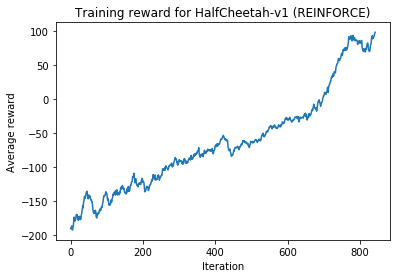

In [8]:
plt.figure()
plt.plot(avg_rewards)
plt.title('Training reward for HalfCheetah-v1 (REINFORCE)')
plt.xlabel('Iteration')
plt.ylabel('Average reward')
plt.savefig('REINFORCE_HalfCheetah_seed0.png')

In [9]:
np.save('results/REINFORCE_HalfCheetah_rewards_seed0.npy', np.asarray(avg_rewards))
np.save('results/REINFORCE_HalfCheetah_steps_seed0.npy', np.asarray(step_list_reinforce))

torch.save(net.state_dict(), 'model/reinforce_HalfCheetah_seed0.pt')

# DDPG

### Setup environment for Actor Critic
- inline plotting
- gym
- directory for logging videos

In [5]:
VISUALIZE = False
SEED = 0
MAX_PATH_LENGTH = 500
NUM_EPISODES = 500
GAMMA = 0.99
BATCH_SIZE = 128

# Environments to be tested on
# env_name = 'InvertedPendulum-v1'
# env_name = 'Pendulum-v0'
env_name = 'HalfCheetah-v1'

env = gym.make(env_name)

print('max_episode_steps =', env._max_episode_steps)
env._max_episode_steps = MAX_PATH_LENGTH

# wrap gym to save videos
if VISUALIZE:
    if not os.path.exists(logdir):
        os.mkdir(logdir)
    env = gym.wrappers.Monitor(env, logdir, force=True, video_callable=lambda episode_id: episode_id%animate_interval==0)

# check observation and action space
discrete = isinstance(env.action_space, gym.spaces.Discrete)
obs_dim = env.observation_space.shape[0]
act_dim = env.action_space.n if discrete else env.action_space.shape[0]
print('obs_dim =', obs_dim)
print('act_dim =', act_dim)

if discrete:
    print("This is a discrete action space, probably not the right algorithm to use")
    
# set random seeds
torch.manual_seed(SEED)
np.random.seed(SEED)

[2018-06-06 17:06:05,754] Making new env: HalfCheetah-v1


max_episode_steps = 1000
obs_dim = 17
act_dim = 6


### Write a weight syncing function
In contrast to DQN, DDPG uses soft weight sychronization. At each time step following training, the actor and critic target network weights are updated to track the rollout networks. 
- target_network.weights <= target_network.weights \* (1 - tau) + source_network.weights \* (tau)

In [6]:
def weightSync(target_model, source_model, tau = 0.001):
    for parameter_target, parameter_source in zip(target_model.parameters(), source_model.parameters()):
        parameter_target.data.copy_((1 - tau) * parameter_target.data + tau * parameter_source.data)

### Write a Replay class that includes all the functionality of a replay buffer
DDPG is an off policy actor-critic method and an identical replay buffer to that used for the previous assignment is applicable here as well (do not include the generate_minibatch method in your Replay class this time). Like before, your constructor for Replay should create an initial buffer of size 1000 when you instantiate it.

The replay buffer should kept to some maximum size (60000), allow adding of samples and returning of samples at random from the buffer. Each sample (or experience) is formed as (state, action, reward, next_state, done). 

In [7]:
class Replay():       
    def __init__(self, max_size=60000, init_length=1000):
        self.capacity = max_size
        self.memory = []
        self.position = init_length
        s = env.reset()
        for i in range(init_length):
            a = np.random.uniform(-1, 1, act_dim)
            next_s, r, done, _ = env.step(a)
            self.memory.append([s, a, r, next_s, done])
            if done:
                s = env.reset()
            else:
                s = next_s

    def push(self, trans):
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = trans
        self.position = (self.position + 1) % self.capacity
        
    def sample(self, batch_size=BATCH_SIZE):
        trans = np.asarray(random.sample(self.memory, batch_size))
        s = np.vstack(trans[:,0])
        a = np.vstack(trans[:,1])
        r = np.vstack(trans[:,2])
        next_s = np.vstack(trans[:,3])
        done = np.vstack(trans[:,4])
        return s, a, r, next_s, done

### Write an Ornstein Uhlenbeck process class for exploration noise
The proccess is described here:
- https://en.wikipedia.org/wiki/Ornstein–Uhlenbeck_process
- http://math.stackexchange.com/questions/1287634/implementing-ornstein-uhlenbeck-in-matlab

You should implement:
- a step / sample method
- reset method

Use theta = 0.15, mu = 0, sigma = 0.3, dt = 0.01

In [8]:
class OrnsteinUhlenbeckProcess():
    def __init__(self, dimension, num_steps, theta=0.15, mu=0., sigma=0.3, dt=0.01):
        super(OrnsteinUhlenbeckProcess, self).__init__()
        self.dimension = dimension
        self.num_steps = num_steps
        self.theta = theta
        self.mu = mu
        self.sigma = sigma
        self.dt = dt
        self.reset()

    def step(self):
        dx = self.theta * (self.mu-self.x_prev) * self.dt + self.sigma * np.sqrt(self.dt)* np.random.randn(self.dimension)
        self.x_prev = self.x_prev + dx
        return self.x_prev

    def reset(self):
        self.x_prev = np.ones(self.dimension) * self.mu

### Write a Deep Neural Network class that creates a dense network of a desired architecture for actor and critic networks


#### Actor
- input and hidden layer activation function: ReLU

- output activation function: Tanh

- hidden_state sizes: 400

- state and action sizes: variable

- number of hidden layers: 2

- batch normalization applied to all hidden layers

- weight initialization: normal distribution with small variance. 

#### Critic
- input and hidden layer activation function: ReLU

- output activation function: None

- hidden_state sizes: 300, 300 + action size

- state and action sizes: variable

- number of hidden layers: 2

- batch normalization applied to all hidden layers prior to the action input

- weight initialization: normal distribution with small variance.

Good baselines can be found in the paper.

In [9]:
# ----------------------------------------------------
# actor model, MLP
# ----------------------------------------------------
# 2 hidden layers, 400 units per layer, tanh output to bound outputs between -1 and 1

class actor(nn.Module):
    def __init__(self, input_size, output_size, hidden_size=400):
        super(actor, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        #self.bn1 = nn.BatchNorm1d(hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        #self.bn2 = nn.BatchNorm1d(hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size)
        
        self.fc1.weight.data.normal_(0, 0.1)
        self.fc2.weight.data.normal_(0, 0.1)
        self.fc3.weight.data.normal_(0, 0.1)

    def forward(self, x):
        x = Variable(Tensor(x))
        #x = F.relu(self.bn1(self.fc1(x)))
        #x = F.relu(self.bn2(self.fc2(x)))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.tanh(self.fc3(x))
        return x
        
# ----------------------------------------------------
# critic model, MLP
# ----------------------------------------------------
# 2 hidden layers, 300 units per layer, ouputs rewards therefore unbounded
# Action not to be included until 2nd layer of critic (from paper). Make sure to formulate your critic.forward() accordingly

class critic(nn.Module):
    def __init__(self, state_size, action_size, output_size=1):
        super(critic, self).__init__()
        self.fc1 = nn.Linear(state_size, 300)
        #self.bn1 = nn.BatchNorm1d(300)
        self.fc2 = nn.Linear(300 + action_size, 300)
        self.fc3 = nn.Linear(300, output_size)
        
        self.fc1.weight.data.normal_(0, 0.1)
        self.fc2.weight.data.normal_(0, 0.1)
        self.fc3.weight.data.normal_(0, 0.1)

    def forward(self, x, action):
        x = Variable(Tensor(x))
        #x = F.relu(self.bn1(self.fc1(x)))
        x = F.relu(self.fc1(x))
        x = torch.cat([x, action], 1)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

### Define DDPG class to encapsulate definition, rollouts, and training

- gamma = 0.99

- actor_lr = 1e-4

- critic_lr = 1e-3

- critic l2 regularization = 1e-2

- noise decay

- noise class

- batch_size = 128

- optimizer: Adam

- loss (critic): mse

Furthermore, you can experiment with action versus parameter space noise. The standard implimentation works with action space noise, howeve parameter space noise has shown to produce excellent results.


In [10]:
class DDPG:
    def __init__(self, input_size = obs_dim, output_size = act_dim, critic_lr = 1e-3, actor_lr = 1e-4, gamma = GAMMA, batch_size = BATCH_SIZE):
        
        self.gamma = GAMMA
        self.batch_size = BATCH_SIZE
        
        # actor
        self.actor = actor(input_size = obs_dim, output_size = act_dim).type(FloatTensor)
        self.actor_target = actor(input_size = obs_dim, output_size = act_dim).type(FloatTensor)
        self.actor_target.load_state_dict(self.actor.state_dict())

        # critic
        self.critic = critic(state_size = obs_dim, action_size = act_dim, output_size = 1).type(FloatTensor)
        self.critic_target = critic(state_size = obs_dim, action_size = act_dim, output_size = 1).type(FloatTensor)
        self.critic_target.load_state_dict(self.critic.state_dict())

        # optimizers
        self.optimizer_actor = torch.optim.Adam(self.actor.parameters(), lr = actor_lr)
        self.optimizer_critic = torch.optim.Adam(self.critic.parameters(), lr = critic_lr, weight_decay=1e-2)
        
        # critic loss
        self.critic_loss = nn.MSELoss()
        
        # noise
        self.noise = OrnsteinUhlenbeckProcess(dimension = act_dim, num_steps = MAX_PATH_LENGTH)

        # replay buffer 
        self.replayBuffer = Replay()
        
        
    def train(self, w):
     
        # sample from Replay
        s, a, r, next_s, done = self.replayBuffer.sample(self.batch_size)
        
        # update critic (create target for Q function)
        next_q = self.critic_target(next_s, self.actor_target(next_s))
        target_q = Variable(Tensor(r + self.gamma * (1-done) * next_q.data.numpy()))
       
        # critic optimizer and backprop step (feed in target and predicted values to self.critic_loss)
        self.critic.zero_grad()        
        q = self.critic(s, Variable(Tensor(a)))  
        loss = self.critic_loss(q, target_q)
        loss.backward()
        self.optimizer_critic.step()

        # update actor (formulate the loss wrt which actor is updated)
        self.actor.zero_grad()
        #logit = net_reinforce(s)
        #action_expert, _ = sample_action(logit, discrete)
        #action_expert = np.clip(action_expert.data.numpy(), -1, 1)        
        loss_actor = -self.critic(s, self.actor(s)).mean()
        #loss_actor2 = F.mse_loss(self.actor(s), Variable(Tensor(action_expert))) * w
        #loss_actor = loss_actor1 + loss_actor2
        
        # actor optimizer and backprop step (loss_actor.backward())
        loss_actor.backward()
        self.optimizer_actor.step()       

        # sychronize target network with fast moving one
        weightSync(self.critic_target, self.critic)
        weightSync(self.actor_target, self.actor)

### Create an instance of your DDPG object
- Print network architectures, confirm they are correct

In [11]:
ddpg = DDPG(input_size = obs_dim, output_size = act_dim)
print(ddpg.actor)
print(ddpg.critic)

actor(
  (fc1): Linear(in_features=17, out_features=400, bias=True)
  (fc2): Linear(in_features=400, out_features=400, bias=True)
  (fc3): Linear(in_features=400, out_features=6, bias=True)
)
critic(
  (fc1): Linear(in_features=17, out_features=300, bias=True)
  (fc2): Linear(in_features=306, out_features=300, bias=True)
  (fc3): Linear(in_features=300, out_features=1, bias=True)
)


### Train DDPG on different environments
Early stopping conditions:
- avg_val > 500 for "InvertedPendulum" 
- avg_val > -150 for "Pendulum" 
- avg_val > 1500 for "HalfCheetah" 



In [12]:
env = NormalizeAction(env) # remap action values for the environment
avg_val = 0

min_epsilon = 0.01
decay_rate = 5/NUM_EPISODES

#for plotting
running_rewards_ddpg = []
step_list_ddpg = []
step_counter = 0

# set term_condition for early stopping according to environment being used
# term_condition = -150 # Pendulum
term_condition = 1500 # HalfCheetah
# term_condition = 450 # InvertedPendulum

#done = False
#while not done:
#    _, _, done, _ = env.step(np.zeros(act_dim, dtype=np.int))

# load policy network from REINFORCE
demo1 = mlp(discrete, obs_dim, act_dim)
demo2 = mlp(discrete, obs_dim, act_dim)
demo3 = mlp(discrete, obs_dim, act_dim)
demo4 = mlp(discrete, obs_dim, act_dim)
demo5 = mlp(discrete, obs_dim, act_dim)
pretrained_model1 = torch.load('model/reinforce_HalfCheetah.pt')
pretrained_model2 = torch.load('model/reinforce_HalfCheetah_seed1.pt')
pretrained_model3 = torch.load('model/reinforce_HalfCheetah_seed2.pt')
pretrained_model4 = torch.load('model/reinforce_HalfCheetah_seed3.pt')
pretrained_model5 = torch.load('model/reinforce_HalfCheetah_seed4.pt')
demo1.load_state_dict(pretrained_model1)
demo2.load_state_dict(pretrained_model2)
demo3.load_state_dict(pretrained_model3)
demo4.load_state_dict(pretrained_model4)
demo5.load_state_dict(pretrained_model5)
demo1.eval()
demo2.eval()
demo3.eval()
demo4.eval()
demo5.eval()

for itr in range(NUM_EPISODES):
    s = env.reset() # get initial state
    ddpg.noise.reset()
    animate_this_episode = (itr % animate_interval == 0) and VISUALIZE    
    episode_reward = 0
    epsilon = min_epsilon + (1.0 - min_epsilon)*np.exp(-decay_rate*itr)

    while True:

        if animate_this_episode:
            env.render()
            time.sleep(0.05)
        
        ddpg.noise.reset()
        
        # use actor to get action, add ddpg.noise.step() to action        
        # remember to put NN in eval mode while testing (to deal with BatchNorm layers) and put it back 
        # to train mode after you're done getting the action
        ddpg.actor.eval()
        action_actor = np.clip(ddpg.actor(np.array([s])).data.numpy(), -1, 1)
        ddpg.actor.train()
        
        # get expert action
        logit1 = demo1(s)
        logit2 = demo2(s)
        logit3 = demo3(s)
        logit4 = demo4(s)
        logit5 = demo5(s)
        action_expert1, _ = sample_action(logit1, discrete)
        action_expert2, _ = sample_action(logit2, discrete)
        action_expert3, _ = sample_action(logit3, discrete)
        action_expert4, _ = sample_action(logit4, discrete)
        action_expert5, _ = sample_action(logit5, discrete)
        action_expert1 = np.clip(action_expert1.data.numpy(), -1, 1)
        action_expert2 = np.clip(action_expert2.data.numpy(), -1, 1)
        action_expert3 = np.clip(action_expert3.data.numpy(), -1, 1)
        action_expert4 = np.clip(action_expert4.data.numpy(), -1, 1)
        action_expert5 = np.clip(action_expert5.data.numpy(), -1, 1)
        
        action_experts = np.vstack([action_expert1, action_expert2, action_expert3, action_expert4, action_expert5])
        std = np.mean(np.std(action_experts, axis=0))
        
        # sample action from expert and actor
        #action = action_actor
        if np.random.uniform() > 2*epsilon*(1-std):
            action = action_actor
        else:
            action = action_expert1 #np.mean(action_experts, axis=0)
        
        action = np.clip(action + epsilon * ddpg.noise.step(), -1, 1)
                
        # step action, get next state, reward, done (keep track of total_reward)
        next_s, r, done, _ = env.step(action)
        next_s = next_s.flatten()
        episode_reward += r

        # populate ddpg.replayBuffer
        ddpg.replayBuffer.push([s, action, r, next_s, done])
        s = next_s
        
        ddpg.train(epsilon)
        step_counter += 1
        
        if done:
            break

    if itr > 100 and avg_val > term_condition:
        break
    
    running_rewards_ddpg.append(episode_reward) # return of this episode
    step_list_ddpg.append(step_counter)

    avg_val = 0.95*avg_val + 0.05*running_rewards_ddpg[-1]
    print("Average value: {} for episode: {}".format(avg_val, itr))

Average value: 2.7185295654323944 for episode: 0
Average value: 13.52709733656018 for episode: 1
Average value: 20.897619761136593 for episode: 2
Average value: 28.638331594992344 for episode: 3
Average value: 35.484239241255295 for episode: 4
Average value: 28.373742409348672 for episode: 5
Average value: 36.1133272397712 for episode: 6
Average value: 42.61311492817002 for episode: 7
Average value: 33.11078913044418 for episode: 8
Average value: 35.13485965008388 for episode: 9
Average value: 28.21985249253202 for episode: 10
Average value: 25.468797032815083 for episode: 11
Average value: 16.372473739701068 for episode: 12
Average value: 10.640838803346995 for episode: 13
Average value: 0.7703563034536938 for episode: 14
Average value: 4.936485441625206 for episode: 15
Average value: 11.589238397234684 for episode: 16
Average value: 17.49975161105023 for episode: 17
Average value: 23.9030587137265 for episode: 18
Average value: 25.413833597689848 for episode: 19
Average value: 33.675

Average value: 1102.5538025587057 for episode: 166
Average value: 1124.841287014667 for episode: 167
Average value: 1141.7027475730677 for episode: 168
Average value: 1162.9089794996528 for episode: 169
Average value: 1173.663090691799 for episode: 170
Average value: 1190.4863044910135 for episode: 171
Average value: 1205.3008986164282 for episode: 172
Average value: 1219.2069976616478 for episode: 173
Average value: 1233.773547756803 for episode: 174
Average value: 1246.3243457203369 for episode: 175
Average value: 1254.9242863121526 for episode: 176
Average value: 1274.557713620202 for episode: 177
Average value: 1279.271030119126 for episode: 178
Average value: 1293.9773721674 for episode: 179
Average value: 1297.0782416229029 for episode: 180
Average value: 1303.065954453394 for episode: 181
Average value: 1315.5378750280756 for episode: 182
Average value: 1326.4840966944755 for episode: 183
Average value: 1335.7217268937807 for episode: 184
Average value: 1345.260269904451 for epi

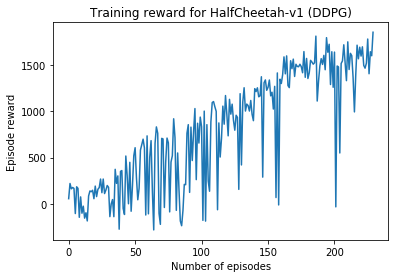

In [14]:
plt.figure()
plt.plot(running_rewards_ddpg)
plt.title('Training reward for HalfCheetah-v1 (DDPG)')
plt.xlabel('Number of episodes')
plt.ylabel('Episode reward')
plt.savefig('DDPG_HalfCheetah_episode_multiple_exp1.png')
plt.show()

## Plot rewards over multiple training runs 
This is provided to generate and plot results for you.

In [2]:
def numpy_ewma_vectorized_v2(data, window):

    alpha = 2/(window + 1.0)
    alpha_rev = 1-alpha
    n = data.shape[0]

    pows = alpha_rev**(np.arange(n+1))
    scale_arr = 1/pows[:-1]
    offset = data[0]*pows[1:]
    pw0 = alpha*alpha_rev**(n-1)

    mult = data.transpose()*pw0*scale_arr
    cumsums = mult.cumsum()
    out = offset + cumsums*scale_arr[::-1]
    return out

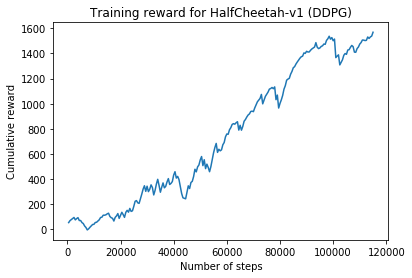

In [16]:
out = numpy_ewma_vectorized_v2(np.asarray(running_rewards_ddpg),20)
step_list_ddpg = np.asarray(step_list_ddpg)

plt.figure()
plt.plot(step_list_ddpg, out)
plt.title('Training reward for HalfCheetah-v1 (DDPG)')
plt.xlabel('Number of steps')
plt.ylabel('Cumulative reward')
plt.savefig('DDPG_HalfCheetah_multiple_exp1.png')
plt.show()

In [17]:
np.save('results/DDPG_HalfCheetah_rewards_multiple_exp1.npy', np.asarray(running_rewards_ddpg))
np.save('results/DDPG_HalfCheetah_steps_multiple_exp1.npy', np.asarray(step_list_ddpg))

In [3]:
r1 = numpy_ewma_vectorized_v2(np.load('results/DDPG_HalfCheetah_rewards_woDemo_exp1.npy'), 20)
r2 = numpy_ewma_vectorized_v2(np.load('results/DDPG_HalfCheetah_rewards_woDemo_exp2.npy'), 20)
r3 = numpy_ewma_vectorized_v2(np.load('results/DDPG_HalfCheetah_rewards_woDemo_exp3.npy'), 20)
r4 = numpy_ewma_vectorized_v2(np.load('results/DDPG_HalfCheetah_rewards_woDemo_exp4.npy'), 20)
r5 = numpy_ewma_vectorized_v2(np.load('results/DDPG_HalfCheetah_rewards_woDemo_exp5.npy'), 20)

t1 = np.load('results/DDPG_HalfCheetah_steps_woDemo_exp1.npy')
t2 = np.load('results/DDPG_HalfCheetah_steps_woDemo_exp2.npy')
t3 = np.load('results/DDPG_HalfCheetah_steps_woDemo_exp3.npy')
t4 = np.load('results/DDPG_HalfCheetah_steps_woDemo_exp4.npy')
t5 = np.load('results/DDPG_HalfCheetah_steps_woDemo_exp5.npy')

r1_explore = numpy_ewma_vectorized_v2(np.load('results/DDPG_HalfCheetah_rewards_exp1.npy'), 20)
r2_explore = numpy_ewma_vectorized_v2(np.load('results/DDPG_HalfCheetah_rewards_exp2.npy'), 20)
r3_explore = numpy_ewma_vectorized_v2(np.load('results/DDPG_HalfCheetah_rewards_exp3.npy'), 20)
r4_explore = numpy_ewma_vectorized_v2(np.load('results/DDPG_HalfCheetah_rewards_exp4.npy'), 20)
r5_explore = numpy_ewma_vectorized_v2(np.load('results/DDPG_HalfCheetah_rewards_exp5.npy'), 20)

t1_explore = np.load('results/DDPG_HalfCheetah_steps_exp1.npy')
t2_explore = np.load('results/DDPG_HalfCheetah_steps_exp2.npy')
t3_explore = np.load('results/DDPG_HalfCheetah_steps_exp3.npy')
t4_explore = np.load('results/DDPG_HalfCheetah_steps_exp4.npy')
t5_explore = np.load('results/DDPG_HalfCheetah_steps_exp5.npy')

r1_loss = numpy_ewma_vectorized_v2(np.load('results/DDPG_HalfCheetah_rewards_augmentLoss_exp1.npy'), 20)
r2_loss = numpy_ewma_vectorized_v2(np.load('results/DDPG_HalfCheetah_rewards_augmentLoss_exp2.npy'), 20)
r3_loss = numpy_ewma_vectorized_v2(np.load('results/DDPG_HalfCheetah_rewards_augmentLoss_exp3.npy'), 20)
r4_loss = numpy_ewma_vectorized_v2(np.load('results/DDPG_HalfCheetah_rewards_augmentLoss_exp4.npy'), 20)
r5_loss = numpy_ewma_vectorized_v2(np.load('results/DDPG_HalfCheetah_rewards_augmentLoss_exp5.npy'), 20)

t1_loss = np.load('results/DDPG_HalfCheetah_steps_augmentLoss_exp1.npy')
t2_loss = np.load('results/DDPG_HalfCheetah_steps_augmentLoss_exp2.npy')
t3_loss = np.load('results/DDPG_HalfCheetah_steps_augmentLoss_exp3.npy')
t4_loss = np.load('results/DDPG_HalfCheetah_steps_augmentLoss_exp4.npy')
t5_loss = np.load('results/DDPG_HalfCheetah_steps_augmentLoss_exp5.npy')

r1_explore_multiple = numpy_ewma_vectorized_v2(np.load('results/DDPG_HalfCheetah_rewards_multiple_exp5.npy'), 20)
r2_explore_multiple = numpy_ewma_vectorized_v2(np.load('results/DDPG_HalfCheetah_rewards_multiple_exp2.npy'), 20)
r3_explore_multiple = numpy_ewma_vectorized_v2(np.load('results/DDPG_HalfCheetah_rewards_multiple_exp4.npy'), 20)

t1_explore_multiple = np.load('results/DDPG_HalfCheetah_steps_multiple_exp5.npy')
t2_explore_multiple = np.load('results/DDPG_HalfCheetah_steps_multiple_exp2.npy')
t3_explore_multiple = np.load('results/DDPG_HalfCheetah_steps_multiple_exp4.npy')

r1_loss_multiple = numpy_ewma_vectorized_v2(np.load('results/DDPG_HalfCheetah_rewards_multiple_augmentLoss_exp2.npy'), 20)

t1_loss_multiple = np.load('results/DDPG_HalfCheetah_steps_multiple_augmentLoss_exp2.npy')

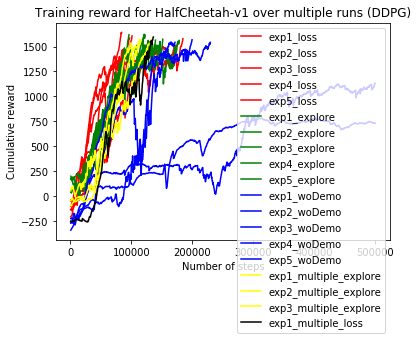

In [6]:
plt.figure()
plt.plot(t1_loss, r1_loss, label='exp1_loss', color='red')
plt.plot(t2_loss, r2_loss, label='exp2_loss', color='red')
plt.plot(t3_loss, r3_loss, label='exp3_loss', color='red')
plt.plot(t4_loss, r4_loss, label='exp4_loss', color='red')
plt.plot(t5_loss, r5_loss, label='exp5_loss', color='red')
plt.plot(t1_explore, r1_explore, label='exp1_explore', color='green')
plt.plot(t2_explore, r2_explore, label='exp2_explore', color='green')
plt.plot(t3_explore, r3_explore, label='exp3_explore', color='green')
plt.plot(t4_explore, r4_explore, label='exp4_explore', color='green')
plt.plot(t5_explore, r5_explore, label='exp5_explore', color='green')
plt.plot(t1, r1, label='exp1_woDemo', color='blue')
plt.plot(t2, r2, label='exp2_woDemo', color='blue')
plt.plot(t3, r3, label='exp3_woDemo', color='blue')
plt.plot(t4, r4, label='exp4_woDemo', color='blue')
plt.plot(t5, r5, label='exp5_woDemo', color='blue')
plt.plot(t1_explore_multiple, r1_explore_multiple, label='exp1_multiple_explore', color='yellow')
plt.plot(t2_explore_multiple, r2_explore_multiple, label='exp2_multiple_explore', color='yellow')
plt.plot(t3_explore_multiple, r3_explore_multiple, label='exp3_multiple_explore', color='yellow')
plt.plot(t1_loss_multiple, r1_loss_multiple, label='exp1_multiple_loss', color='black')

plt.title('Training reward for HalfCheetah-v1 over multiple runs (DDPG)')
plt.xlabel('Number of steps')
plt.ylabel('Cumulative reward')
plt.legend()
plt.savefig('DDPG_HalfCheetah_compare.png')
plt.show()

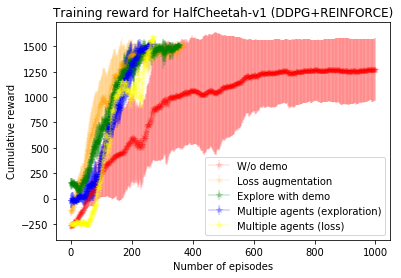

In [7]:
r = [r1, r2, r3, r4, r5]
r_std = [np.std(x) for x in itertools.zip_longest(*r, fillvalue=1500)]
r = [sum(x)/5 for x in itertools.zip_longest(*r, fillvalue=1500)]

r_loss = [r1_loss, r2_loss, r3_loss, r4_loss, r5_loss]
r_loss_std = [np.std(x) for x in itertools.zip_longest(*r_loss, fillvalue=1500)]
r_loss = [sum(x)/5 for x in itertools.zip_longest(*r_loss, fillvalue=1500)]

r_explore = [r1_explore, r2_explore, r3_explore, r4_explore, r5_explore]
r_explore_std = [np.std(x) for x in itertools.zip_longest(*r_explore, fillvalue=1500)]
r_explore = [sum(x)/5 for x in itertools.zip_longest(*r_explore, fillvalue=1500)]

r_multiple = [r1_explore_multiple, r2_explore_multiple, r3_explore_multiple]
r_multiple_std = [np.std(x) for x in itertools.zip_longest(*r_multiple, fillvalue=1500)]
r_multiple = [sum(x)/3 for x in itertools.zip_longest(*r_multiple, fillvalue=1500)]

r_loss_multiple = [r1_loss_multiple]
r_loss_multiple_std = [np.std(x) for x in itertools.zip_longest(*r_loss_multiple, fillvalue=1500)]
r_loss_multiple = [sum(x)/1 for x in itertools.zip_longest(*r_loss_multiple, fillvalue=1500)]

plt.figure()
plt.errorbar(range(len(r)), r, yerr=r_std, label='W/o demo', fmt='-*', color='red', alpha=0.1)
plt.errorbar(range(len(r_loss)), r_loss, yerr=r_loss_std, label='Loss augmentation', fmt='-*', color='orange', alpha=0.1)
plt.errorbar(range(len(r_explore)), r_explore, yerr=r_explore_std, label='Explore with demo', fmt='-*', color='green', alpha=0.2)
plt.errorbar(range(len(r_multiple)), r_multiple, yerr=r_multiple_std, label='Multiple agents (exploration)', fmt='-*', color='blue', alpha=0.2)
plt.errorbar(range(len(r_loss_multiple)), r_loss_multiple, yerr=r_loss_multiple_std, label='Multiple agents (loss)', fmt='-*', color='yellow', alpha=0.2)

plt.title('Training reward for HalfCheetah-v1 (DDPG+REINFORCE)')
plt.xlabel('Number of episodes')
plt.ylabel('Cumulative reward')
plt.legend()
plt.savefig('DDPG_HalfCheetah_compare2.png')
plt.show()